In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:

!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 98% 1.05G/1.06G [00:13<00:00, 60.2MB/s]
100% 1.06G/1.06G [00:13<00:00, 82.8MB/s]


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')

zip_ref.extractall('/content')

zip_ref.close()

In [ ]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import joblib
from sklearn.model_selection import GridSearchCV
import cv2
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [ ]:
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)
validation_ds= keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels ='inferred',
    label_mode = 'int',
    batch_size = 32,
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [ ]:
folder_path = f"/content/Dataset"
os.makedirs(folder_path, exist_ok=True)

# define path
confusion_image_path = os.path.join(folder_path, 'confusion matrix.png')
classification_file_path = os.path.join(folder_path, 'classification_report.txt')
model_file_path = os.path.join(folder_path, "svm_model.pkl")

# Path dataset
dataset_dir = "/content/Dataset"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test1")

In [ ]:
train_images = "/content/train"
features = []
labels = []
image_size = (50, 50)

# Proses train images
for image in tqdm(train_images, desc="Processing Train Images"):
    if image[0:3] == 'cats' :
        label = 0
    else :
        label = 1
    image_read = cv2.imread(train_dir+"/"+image)



    labels.append(label)

Processing Train Images: 100%|██████████| 14/14 [00:00<00:00, 19379.62it/s]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

training_set = datagen.flow_from_directory(
        "/content/train",
        target_size=(64, 64),
        batch_size=32,
        class_mode="binary"
      )

Found 20000 images belonging to 2 classes.


In [ ]:
datagen1 = ImageDataGenerator(rescale=1./255)

test_set = datagen1.flow_from_directory(
        "/content/test",
        target_size=(64, 64),
        batch_size=32,
        class_mode="binary"
      )

Found 5000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

In [ ]:
cnn = tf.keras.models.Sequential()

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [ ]:
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))

In [ ]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 272,545 (1.04 MB)

 Trainable params: 272,545 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

In [ ]:
r=cnn.fit(x = training_set, validation_data = test_set, epochs = 10)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 91s 144ms/step - accuracy: 0.7609 - loss: 0.5172 - val_accuracy: 0.7790 - val_loss: 0.5018
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - accuracy: 0.7647 - loss: 0.4992 - val_accuracy: 0.7994 - val_loss: 0.5037
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 160ms/step - accuracy: 0.7680 - loss: 0.4954 - val_accuracy: 0.8012 - val_loss: 0.5316
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 146ms/step - accuracy: 0.7833 - loss: 0.4689 - val_accuracy: 0.7838 - val_loss: 0.6116
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 140ms/step - accuracy: 0.7860 - loss: 0.4576 - val_accuracy: 0.7926 - val_loss: 0.5645
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 89s 140ms/step - accuracy: 0.7908 - loss: 0.4458 - val_accuracy: 0.8108 - val_loss: 0.4403
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step - accuracy: 0.7925 - loss: 0.4445 - val_accuracy: 0.8176 - val_loss: 0.4390
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 139ms/step - accuracy: 0.8056 - los

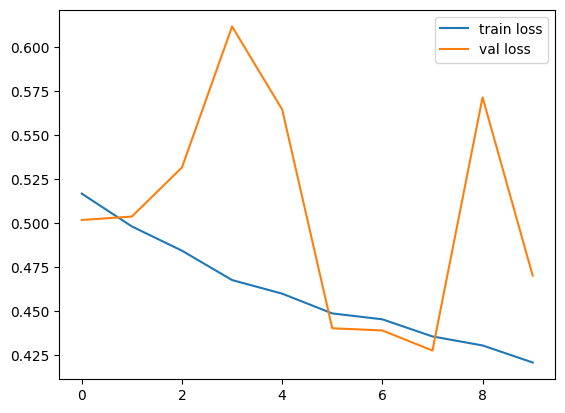

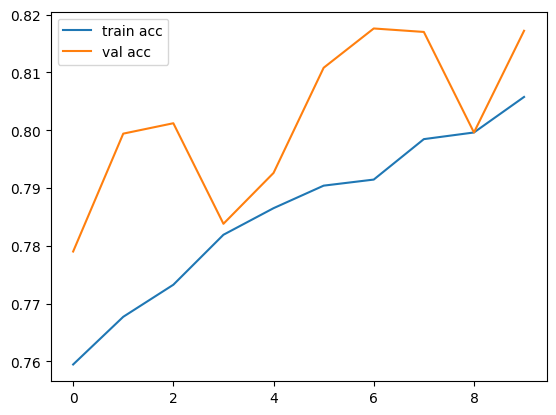

In [ ]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
cnn.save('./model_rcat_dog.h5')
# Taking the sample image converting the image to an array and predicting the result
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/content/test/cats/cat.10007.jpg', target_size = (64,64))

test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
if result[0]<0:
    print("The image classified is cat")
else:
    print("The image classified is dog")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
The image classified is cat
